In [41]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [42]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [43]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15T19:12:23.740Z,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15T19:04:27.070Z,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15T19:00:38.627Z,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15T18:52:46.384Z,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [44]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15 19:12:23.740000+00:00,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15 19:04:27.070000+00:00,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15 19:00:38.627000+00:00,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15 18:52:46.384000+00:00,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [45]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource


In [46]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag
0,37.3840,-117.107500,1.10,1.30
1,38.1810,-117.818000,7.30,1.40
2,61.3407,-149.885200,30.00,1.50
3,62.8703,-150.762500,111.30,2.10
4,64.0145,-148.765700,1.90,1.50
...,...,...,...,...
33889,39.4215,-110.312333,-1.56,1.83
33890,38.8250,-122.797167,2.68,0.41
33891,38.5375,-119.382100,0.00,1.40
33892,55.3724,-159.286100,15.00,1.80


In [47]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
dtype: int64

In [48]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [49]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [50]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['latitude'], axis = 1)

y = cleaned_df_dropped[['latitude']]

In [51]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((33888, 3), (33888, 1))

In [52]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [53]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [54]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 68.38989737299539, 	R2 score: 0.8347722965897368, 	Model score: 0.8347722965897368
n_estimators=3:
	Mean Squared Error: 62.48718574378521, 	R2 score: 0.8490330503538236, 	Model score: 0.8490330503538236
n_estimators=4:
	Mean Squared Error: 57.678809274506186, 	R2 score: 0.8606499269930423, 	Model score: 0.8606499269930423
n_estimators=5:
	Mean Squared Error: 54.79238866994842, 	R2 score: 0.8676234225806445, 	Model score: 0.8676234225806445
n_estimators=6:
	Mean Squared Error: 53.501562380911764, 	R2 score: 0.8707420156979275, 	Model score: 0.8707420156979275
n_estimators=7:
	Mean Squared Error: 53.038929350519005, 	R2 score: 0.8718597216175114, 	Model score: 0.8718597216175114
n_estimators=8:
	Mean Squared Error: 52.85420421664551, 	R2 score: 0.8723060113591907, 	Model score: 0.8723060113591907
n_estimators=9:
	Mean Squared Error: 52.90368756865168, 	R2 score: 0.8721864612366861, 	Model score: 0.8721864612366861
n_estimators=10:
	Mean Squared Error:

In [55]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 68.38989737299539, 	R2: 0.8347722965897368, 	Model score: 0.8347722965897368
n_estimators=3:
	Mean Squared Error: 62.48718574378521, 	R2: 0.8490330503538236, 	Model score: 0.8490330503538236
n_estimators=4:
	Mean Squared Error: 57.678809274506186, 	R2: 0.8606499269930423, 	Model score: 0.8606499269930423
n_estimators=5:
	Mean Squared Error: 54.79238866994842, 	R2: 0.8676234225806445, 	Model score: 0.8676234225806445
n_estimators=6:
	Mean Squared Error: 53.501562380911764, 	R2: 0.8707420156979275, 	Model score: 0.8707420156979275
n_estimators=7:
	Mean Squared Error: 53.038929350519005, 	R2: 0.8718597216175114, 	Model score: 0.8718597216175114
n_estimators=8:
	Mean Squared Error: 52.85420421664551, 	R2: 0.8723060113591907, 	Model score: 0.8723060113591907
n_estimators=9:
	Mean Squared Error: 52.90368756865168, 	R2: 0.8721864612366861, 	Model score: 0.8721864612366861
n_estimators=10:
	Mean Squared Error: 52.11443734841228, 	R2: 0.8740932633568146, 	Mo

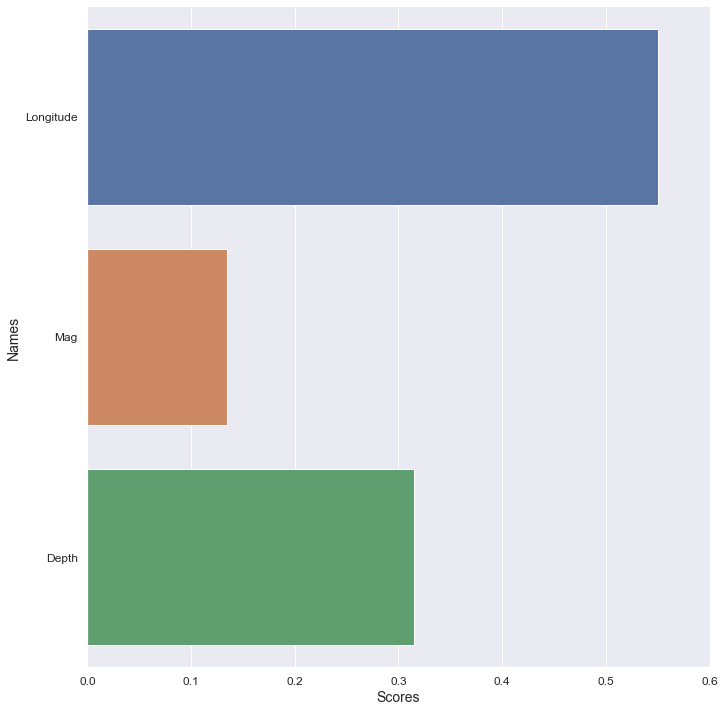

In [56]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['longitude', 'mag', 'depth']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [57]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 3389  3390  3391 ... 33885 33886 33887] | test: [   0    1    2 ... 3386 3387 3388]
Train: [    0     1     2 ... 33885 33886 33887] | test: [3389 3390 3391 ... 6775 6776 6777]
Train: [    0     1     2 ... 33885 33886 33887] | test: [ 6778  6779  6780 ... 10164 10165 10166]
Train: [    0     1     2 ... 33885 33886 33887] | test: [10167 10168 10169 ... 13553 13554 13555]
Train: [    0     1     2 ... 33885 33886 33887] | test: [13556 13557 13558 ... 16942 16943 16944]
Train: [    0     1     2 ... 33885 33886 33887] | test: [16945 16946 16947 ... 20331 20332 20333]
Train: [    0     1     2 ... 33885 33886 33887] | test: [20334 20335 20336 ... 23720 23721 23722]
Train: [    0     1     2 ... 33885 33886 33887] | test: [23723 23724 23725 ... 27109 27110 27111]
Train: [    0     1     2 ... 33885 33886 33887] | test: [27112 27113 27114 ... 30497 30498 30499]
Train: [    0     1     2 ... 30497 30498 30499] | test: [30500 30501 30502 ... 33885 33886 33887]


In [58]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[-1.85952451 -2.20583568 -2.30416952 -2.24393852 -2.32929389 -1.96306244
 -2.02379677 -2.14757223 -2.11695133 -2.09216531]
MAE: -2.129 (0.142)


In [59]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [60]:
##create elements for plot validation curve
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

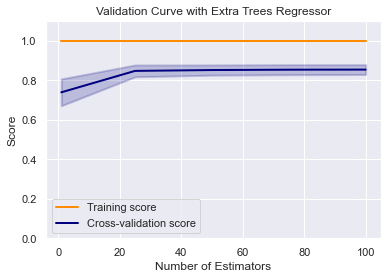

In [61]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [62]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_lat = y_test
lats = actual_lat['latitude'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(lats, testpredict)
test_mse = mean_squared_error(y_test, testpred)

test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 6.888
MAE: 1.906


In [63]:
print(actual_lat)

        latitude
8338   36.562500
8426   -9.963400
3079   40.160500
5192   38.839832
32429 -23.717300
...          ...
15274  59.876800
17005  36.842667
16140  19.480000
2461   38.190800
18143  40.025000

[11184 rows x 1 columns]


In [64]:
lat_pred = actual_lat
lat_pred['Predicted'] = testpredict


In [65]:
lat_pred = lat_pred.rename(columns={'latitude': 'Actual'})

In [66]:
lat_pred

,Actual,Predicted
8338,36.562500,38.091284
8426,-9.963400,10.280262
3079,40.160500,40.013081
5192,38.839832,38.835617
32429,-23.717300,-22.395657
...,...,...
15274,59.876800,59.840347
17005,36.842667,35.566857
16140,19.480000,23.623542
2461,38.190800,38.093047


In [67]:
#join dataframes for actual and predicted with original dataframe
lat_pred_all = lat_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lat_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
8338,36.562500,38.091284,2021-12-07 15:32:01.140000+00:00,36.562500,-121.142333,4.35,1.38,md,14.0,120.00,...,2021-12-14T06:11:11.550Z,"3km N of Pinnacles, CA",earthquake,0.28,1.49,0.327000,13.0,reviewed,nc,nc
8426,-9.963400,10.280262,2021-12-07 10:28:00.447000+00:00,-9.963400,161.043300,170.33,5.40,mww,NaN,25.00,...,2021-12-08T10:31:06.697Z,"110 km WNW of Kirakira, Solomon Islands",earthquake,4.70,5.80,0.098000,10.0,reviewed,us,us
3079,40.160500,40.013081,2021-12-24 04:06:37.017000+00:00,40.160500,-119.622500,6.20,0.30,ml,3.0,241.35,...,2021-12-29T18:39:58.816Z,"23 km N of Sutcliffe, Nevada",earthquake,NaN,8.30,0.000000,1.0,reviewed,nn,nn
5192,38.839832,38.835617,2021-12-17 20:17:55.100000+00:00,38.839832,-122.819336,1.36,0.65,md,22.0,56.00,...,2021-12-17T20:40:12.214Z,"9km WNW of Cobb, CA",earthquake,0.22,0.51,0.270000,4.0,automatic,nc,nc
32429,-23.717300,-22.395657,2022-02-19 14:45:11.512000+00:00,-23.717300,-175.527600,10.00,5.10,mb,NaN,154.00,...,2022-02-19T15:03:02.040Z,"270 km SSW of ‘Ohonua, Tonga",earthquake,7.40,1.80,0.092000,38.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15274,59.876800,59.840347,2021-12-28 08:01:37.573000+00:00,59.876800,-153.452900,130.80,2.00,ml,NaN,NaN,...,2022-01-24T16:20:00.261Z,"37 km ENE of Pedro Bay, Alaska",earthquake,NaN,0.30,NaN,NaN,reviewed,ak,ak
17005,36.842667,35.566857,2022-02-01 07:49:18.629000+00:00,36.842667,-97.798333,7.33,1.57,ml,69.0,86.00,...,2022-02-02T20:46:24.887Z,"6 km NW of Medford, Oklahoma",earthquake,NaN,0.50,0.250000,8.0,reviewed,ok,ok
16140,19.480000,23.623542,2022-02-04 03:13:36.450000+00:00,19.480000,-155.647500,3.58,1.10,md,17.0,107.00,...,2022-02-04T04:10:46.780Z,"22 km E of Honaunau-Napoopoo, Hawaii",earthquake,0.38,0.83,0.208773,10.0,reviewed,hv,hv
2461,38.190800,38.093047,2021-12-26 21:05:20.680000+00:00,38.190800,-117.866200,9.50,1.40,ml,16.0,112.60,...,2021-12-28T20:46:46.044Z,"30 km SE of Mina, Nevada",earthquake,NaN,2.00,0.950000,4.0,reviewed,nn,nn


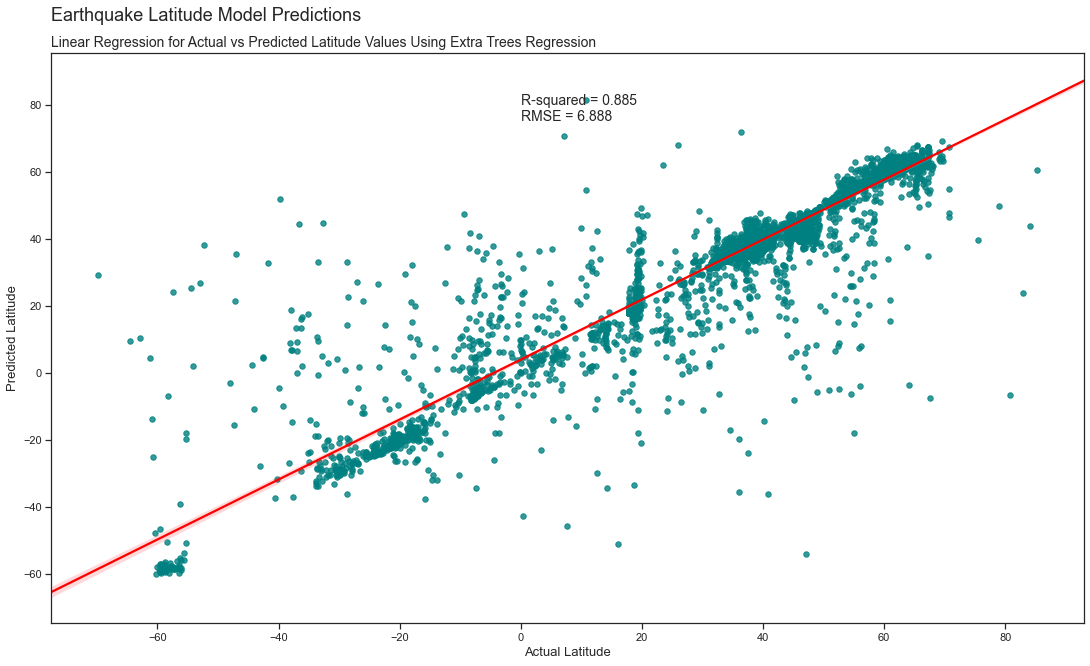

In [68]:
#plot actual vs predicted values
x = np.array(lat_pred_all['latitude'])
y = np.array(testpredict)
# r2_score(y_test, y_pred)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Latitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lat_pred_all['latitude'], testpredict)), (0, 80),  fontsize=14)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 75), fontsize=14)

fig.savefig('../static/images/extratrees_latnotime_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [69]:
# make a single prediction
from datetime import datetime
mag = float(input('Enter a magnitude: '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
# date_input = input('Enter a date (yyyy/mm/dd): ')
# time_input = input('Enter a time in UTC: ')
# datetime_str = date_input + ' '+ time_input
# date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
# date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[mag,lon,depth]]
y_pred = best_model.predict(single_features)
print('Predicted Latitude: %g' % y_pred)

Predicted Latitude: 15.0278


Test with new data from USGS


In [70]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-18T18:59:09.300Z,38.828499,-122.810165,1.59,0.85,md,13.0,46.00,0.005097,0.0100,...,2022-03-18T19:00:47.707Z,"7km NW of The Geysers, CA",earthquake,0.29,0.93,NaN,1.0,automatic,nc,nc
1,2022-03-18T18:49:20.820Z,34.000832,-117.478332,4.79,1.28,ml,19.0,130.00,0.192900,0.4100,...,2022-03-18T18:53:02.905Z,"1km SSE of Glen Avon, CA",earthquake,2.04,5.04,0.231,7.0,automatic,ci,ci
2,2022-03-18T18:44:11.367Z,38.547300,-119.492700,3.40,1.30,ml,10.0,162.94,0.044000,0.1285,...,2022-03-18T18:48:25.984Z,"2 km SSE of Coleville, California",earthquake,NaN,0.40,0.190,8.0,automatic,nn,nn
3,2022-03-18T18:43:43.590Z,35.860000,-117.689000,7.91,0.47,ml,10.0,80.00,0.080230,0.1000,...,2022-03-18T18:47:17.849Z,"21km ESE of Little Lake, CA",earthquake,0.30,0.76,0.075,4.0,automatic,ci,ci
4,2022-03-18T18:27:23.240Z,36.007999,-120.568001,2.97,1.08,md,10.0,111.00,0.025490,0.0500,...,2022-03-18T18:28:56.881Z,"17km NW of Parkfield, CA",earthquake,0.47,0.75,0.240,3.0,automatic,nc,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,2022-03-17T19:23:55.740Z,36.938000,-120.192833,15.54,1.87,md,8.0,161.00,0.278000,0.0300,...,2022-03-18T01:56:12.790Z,"12km WSW of Madera, CA",earthquake,0.75,1.30,0.233,14.0,reviewed,nc,nc
287,2022-03-17T19:21:18.570Z,36.171000,-117.594833,5.70,0.73,ml,10.0,181.00,0.063340,0.0800,...,2022-03-17T23:48:51.337Z,"35km ENE of Coso Junction, CA",earthquake,0.29,0.49,0.068,5.0,reviewed,ci,ci
288,2022-03-17T19:11:02.594Z,-26.910000,-175.962000,10.00,5.10,mww,NaN,55.00,2.912000,1.2000,...,2022-03-17T19:35:58.040Z,south of Tonga,earthquake,9.60,1.80,0.083,14.0,reviewed,us,us
289,2022-03-17T19:07:03.060Z,36.006500,-117.138500,5.21,1.45,ml,23.0,57.00,0.164600,0.1300,...,2022-03-17T23:48:15.330Z,"35km NE of Trona, CA",earthquake,0.22,1.10,0.090,17.0,reviewed,ci,ci


In [71]:
#dropped columns not needed
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag
0,38.828499,-122.810165,1.59,0.85
1,34.000832,-117.478332,4.79,1.28
2,38.547300,-119.492700,3.40,1.30
3,35.860000,-117.689000,7.91,0.47
4,36.007999,-120.568001,2.97,1.08
...,...,...,...,...
286,36.938000,-120.192833,15.54,1.87
287,36.171000,-117.594833,5.70,0.73
288,-26.910000,-175.962000,10.00,5.10
289,36.006500,-117.138500,5.21,1.45


In [72]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [73]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['latitude'], axis = 1)

y_test_data = cleaned_test_df[['latitude']]


In [74]:
#use best model to predict data
pred_data_y = best_model.predict(X_test_data)


In [75]:
#create dataframe with predicted values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Predicted
0,38.828499,-122.810165,1.59,0.85,38.828751
1,34.000832,-117.478332,4.79,1.28,34.482711
2,38.547300,-119.492700,3.40,1.30,38.546371
3,35.860000,-117.689000,7.91,0.47,35.850894
4,36.007999,-120.568001,2.97,1.08,36.115789
...,...,...,...,...,...
286,36.938000,-120.192833,15.54,1.87,36.184229
287,36.171000,-117.594833,5.70,0.73,35.647776
288,-26.910000,-175.962000,10.00,5.10,-27.064939
289,36.006500,-117.138500,5.21,1.45,34.800519


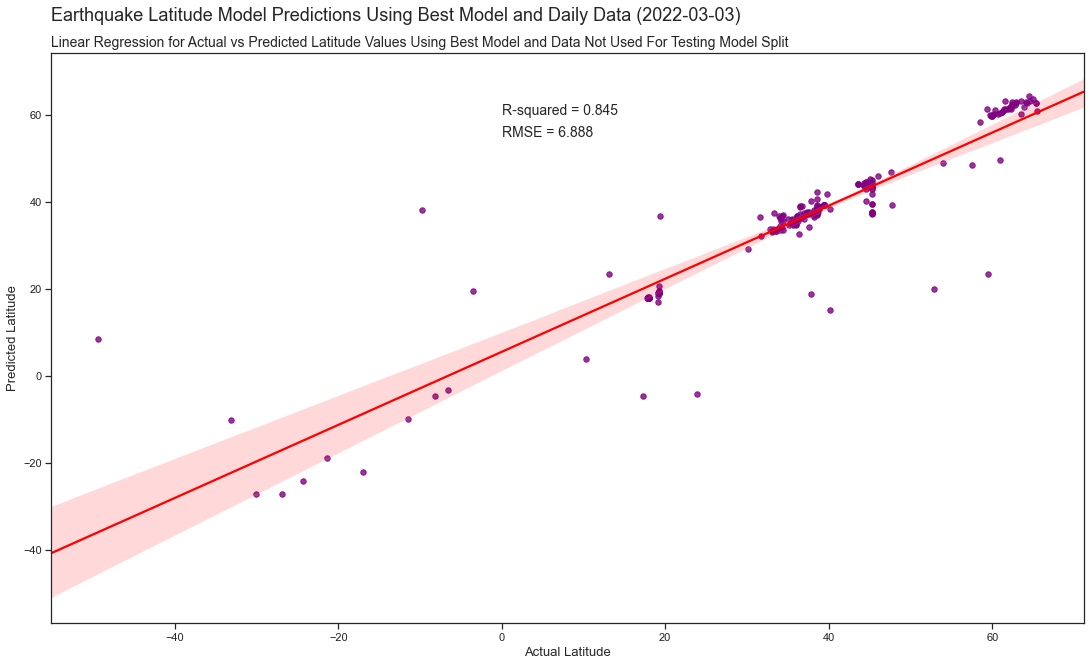

In [76]:
#create grpah for actual vs predicted values
x = np.array(test_pred_data['latitude'])
y = np.array(pred_data_y)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Latitude Model Predictions Using Best Model and Daily Data (2022-03-03)', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 60),  fontsize=14)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 55), fontsize=14)

fig.savefig('../static/images/extratrees_latnotime_linear_sns_daily.png', bbox_inches='tight',dpi=600)
plt.show()

In [77]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")

Connected to database...


In [78]:
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lat_pred_all.to_sql('earthquake_etrees_lat_notime', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lat_pred_all.to_sql('earthquake_etrees_lat_notime', conn, if_exists='replace', index=False)

In [79]:
# Close connection to SQLite database
conn.close()
connection.close()